In [17]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from skimage.color import rgb2lab
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

In [8]:
RAW_DATA = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

In [11]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [10]:
image_paths = [os.path.join(RAW_DATA, fname) for fname in os.listdir(RAW_DATA)][:50000]
np.random.shuffle(image_paths)

train_paths = image_paths[:45000]
val_paths = image_paths[45000:]

In [12]:
class PreprocessingSequence(Sequence):
    def __init__(self, image_paths, batch_size, img_size):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        L_images, AB_images = [], []

        for img_path in batch_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0

            lab = rgb2lab(img)
            L = lab[:, :, 0] / 100.0
            AB = lab[:, :, 1:] / 128.0

            L_images.append(L.reshape(self.img_size + (1,)))
            AB_images.append(AB)

        return np.array(L_images), np.array(AB_images)

train_gen = PreprocessingSequence(train_paths, BATCH_SIZE, IMG_SIZE)
val_gen = PreprocessingSequence(val_paths, BATCH_SIZE, IMG_SIZE)

In [18]:
def create_model():
    input_l = Input(shape= IMG_SIZE+(1,))

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_l)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)(c4)  # Bottleneck

    u1 = UpSampling2D((2, 2))(c4)
    u1 = concatenate([u1, c3])
    u1 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    u1 = BatchNormalization()(u1)

    u2 = UpSampling2D((2, 2))(u1)
    u2 = concatenate([u2, c2])
    u2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = BatchNormalization()(u2)

    u3 = UpSampling2D((2, 2))(u2)
    u3 = concatenate([u3, c1])
    u3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    u3 = BatchNormalization()(u3)

    u4 = UpSampling2D((2, 2))(u3)
    u4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    u4 = BatchNormalization()(u4)

    output_ab = Conv2D(2, (3, 3), activation='tanh', padding='same')(u4)

    model = Model(inputs=input_l, outputs=output_ab, name="colorize_model")
    return model


In [19]:
model = create_model()
model.summary()

I0000 00:00:1751472830.495630      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "colorize_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 512)    │          2,048 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,031,906 (26.82 MB)

 Trainable params: 7,029,026 (26.81 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [20]:
model.compile(optimizer='adam', loss='mse')

In [21]:
model.fit(train_gen, validation_data=val_gen, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751472864.529660     101 service.cc:148] XLA service 0x7f6ab4025810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751472864.530600     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751472865.626159     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1407 ━━━━━━━━━━━━━━━━━━━━ 2:11 94ms/step - loss: 0.5440  

I0000 00:00:1751472877.904003     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 551s 374ms/step - loss: 0.0205 - val_loss: 0.0082
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 215s 153ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 215s 153ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 211s 150ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 213s 151ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 207s 147ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 205s 146ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 209s 149ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 196s 139ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 198s 141ms/step - loss: 0.0072 - val_loss: 0.0071


In [22]:
model.save('/kaggle/working/colorize_model.keras')

In [26]:
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, rgb2lab
import cv2
import numpy as np

def prediction(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img_input = img / 255.0

    lab = rgb2lab(img_input)
    L = lab[:, :, 0] / 100.0
    AB = lab[:, :, 1:] / 128.0

    L_input = L.reshape(1, 128, 128, 1)

    pred_AB = model.predict(L_input)[0]
    pred_AB_rescaled = pred_AB * 128
    true_AB_rescaled = AB * 128

    L_scaled = L * 100
    lab_pred = np.zeros((128, 128, 3))
    lab_pred[:, :, 0] = L_scaled
    lab_pred[:, :, 1:] = pred_AB_rescaled
    rgb_pred = lab2rgb(lab_pred)

    # lab_true = np.zeros((128, 128, 3))
    # lab_true[:, :, 0] = L_scaled
    # lab_true[:, :, 1:] = true_AB_rescaled
    # rgb_true = lab2rgb(lab_true)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(L, cmap='gray')
    axs[0].set_title("Input")
    axs[0].axis('off')

    axs[1].imshow(rgb_pred)
    axs[1].set_title("Predicted")
    axs[1].axis('off')

    axs[2].imshow(img)
    axs[2].set_title("Real")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


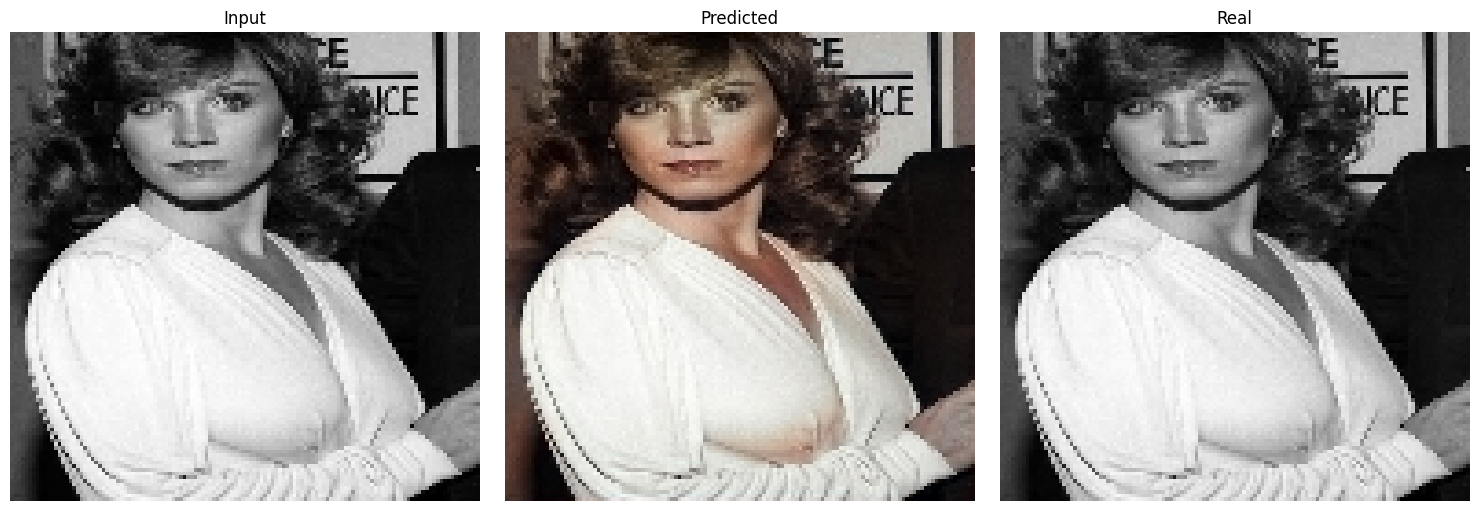

In [27]:
prediction('/kaggle/input/test-img/test.jpg', model)